# Import Libraries and Load dataset
importing necessary libraries for data manipulation (pandas, numpy), machine learning (sklearn modules for model selection, preprocessing, metrics), handling imbalanced data (imblearn), dimensionality reduction (PCA), and visualization (matplotlib.pyplot, seaborn). It also includes xgboost and joblib for the XGBoost model and saving/loading objects, and shap for model interpretability. 

In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, 
                             recall_score, f1_score, roc_auc_score, roc_curve, log_loss)
from imblearn.over_sampling import SMOTE
import warnings
import xgboost as xgb
import joblib
import shap
import os
from datetime import datetime
warnings.filterwarnings('ignore')

The dataset is loaded from a CSV file named 'Heart Disease indicator (version 1).csv' into a pandas DataFrame. 

In [2]:
# Load the dataset
df = pd.read_csv('Heart Disease indicator (version 1).csv')

# Data Exploration

Basic exploration is performed to understand the dataset's structure, including printing the shape, the first few rows, column information (data types and non-null counts), and checking for missing values.   
The distribution of the target variable 'HeartDisease' is checked using value_counts(), revealing a significant class imbalance where the 'No' class is much more frequent than the 'Yes' class. A bar plot visualizes this imbalance.

In [3]:
# View five rows of dataset in table
df.head()

,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadAngina,HadStroke,...,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,HeartDisease
0,Female,Very good,4,0,Within past year (anytime less than 12 months ...,Yes,9,None of them,No,No,...,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No,No
1,Male,Very good,0,0,Within past year (anytime less than 12 months ...,Yes,6,None of them,No,No,...,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No,No
2,Male,Very good,0,0,Within past year (anytime less than 12 months ...,No,8,"6 or more, but not all",No,No,...,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes,No
3,Female,Fair,5,0,Within past year (anytime less than 12 months ...,Yes,9,None of them,No,No,...,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes,No
4,Female,Good,3,15,Within past year (anytime less than 12 months ...,Yes,5,1 to 5,No,No,...,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No,No


In [4]:
#check shape of dataset number of rows and columns
df.shape

(246022, 39)

# Data Preprocessing

Handling Missing Values: The code includes a step to handle missing values by imputing numerical columns with the median and categorical columns with the mode. However, the output of df.isnull().sum() shows no missing values in this specific dataset.   
BMI Verification: The code verifies the BMI calculation using 'WeightInKilograms' and 'HeightInMeters' and recalculates BMI where discrepancies exist, ensuring data consistency.    
Removing Duplicates: Duplicate rows are removed from the dataset to avoid bias and improve model performance. The shape of the DataFrame after removing duplicates is printed. 

In [5]:
# Check for missing value
df.isnull().sum()

Sex                          0
GeneralHealth                0
PhysicalHealthDays           0
MentalHealthDays             0
LastCheckupTime              0
PhysicalActivities           0
SleepHours                   0
RemovedTeeth                 0
HadAngina                    0
HadStroke                    0
HadAsthma                    0
HadSkinCancer                0
HadCOPD                      0
HadDepressiveDisorder        0
HadKidneyDisease             0
HadArthritis                 0
HadDiabetes                  0
DeafOrHardOfHearing          0
BlindOrVisionDifficulty      0
DifficultyConcentrating      0
DifficultyWalking            0
DifficultyDressingBathing    0
DifficultyErrands            0
SmokerStatus                 0
ECigaretteUsage              0
ChestScan                    0
RaceEthnicityCategory        0
AgeCategory                  0
HeightInMeters               0
WeightInKilograms            0
BMI                          0
AlcoholDrinkers              0
HIVTesti

In [6]:
# Check for duplicate
df.duplicated().sum()

36

In [7]:
# Drop any duplicate data find in dataseta and keep first
df.drop_duplicates(keep='first', inplace=True)

In [8]:
# Handle missing values
# For numerical columns, impute with median; for categorical, impute with mode
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns.drop('HeartDisease', errors='ignore')

for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)

for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [9]:
# Verify BMI calculation (HeightInM and WeightInK should match BMI)
# Recalculate BMI where necessary: BMI = weight (kg) / (height (m))^2
df['Calculated_BMI'] = df['WeightInKilograms'] / (df['HeightInMeters'] ** 2)
df['BMI'] = np.where(abs(df['BMI'] - df['Calculated_BMI']) > 0.1, df['Calculated_BMI'], df['BMI'])
df.drop(columns=['Calculated_BMI'], inplace=True)

# Encoding Categorical Features
Binary categorical columns (excluding the target) are identified and encoded using LabelEncoder. The target variable 'HeartDisease' is also label encoded.   
Multi-class categorical columns are one-hot encoded using pd.get_dummies to convert them into a numerical format suitable for machine learning models. The shape and first few rows of the DataFrame after encoding are printed. 

In [10]:
# Label encode the target variable (HeartDise)
le_target = LabelEncoder()
df['HeartDisease'] = le_target.fit_transform(df['HeartDisease'])

In [11]:
# Encoding all the value in the categoricals columns 
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    # Save the label encoder for Flask app
    joblib.dump(le, f'label_encoder_{col}.joblib')

Separates the features (X) and the target variable (y). It drops the 'HeartDisease' column from the DataFrame to create the feature set X, and assigns the 'HeartDisease' column to the target variable y.

In [12]:
# Separate features and target
X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']

In [13]:
# View the target variable whether to resample or not
y.value_counts()

HeartDisease
0    232551
1     13435
Name: count, dtype: int64

The output shows that there is a significant class imbalance, with '0' (no heart disease) having a much higher count (232,551) than '1' (heart disease) (13,435).

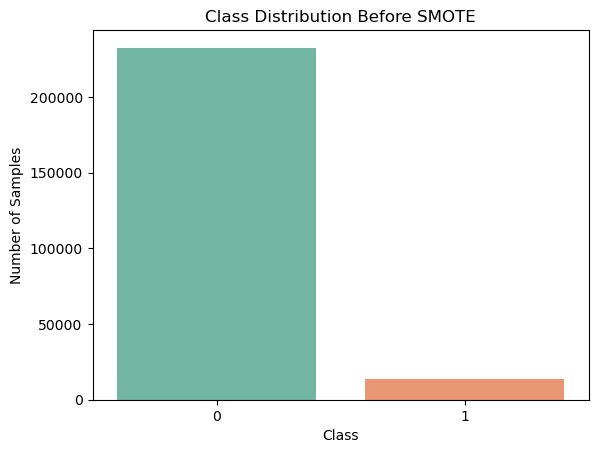

In [14]:
# Basic bar plot for class distribution
sns.countplot(x=y, palette='Set2')

plt.title("Class Distribution Before SMOTE")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

# Handling Class Imbalanced
The plot titled "Class Distribution Before SMOTE" clearly shows the imbalance, with the bar for class 0 being much taller than the bar for class 1.

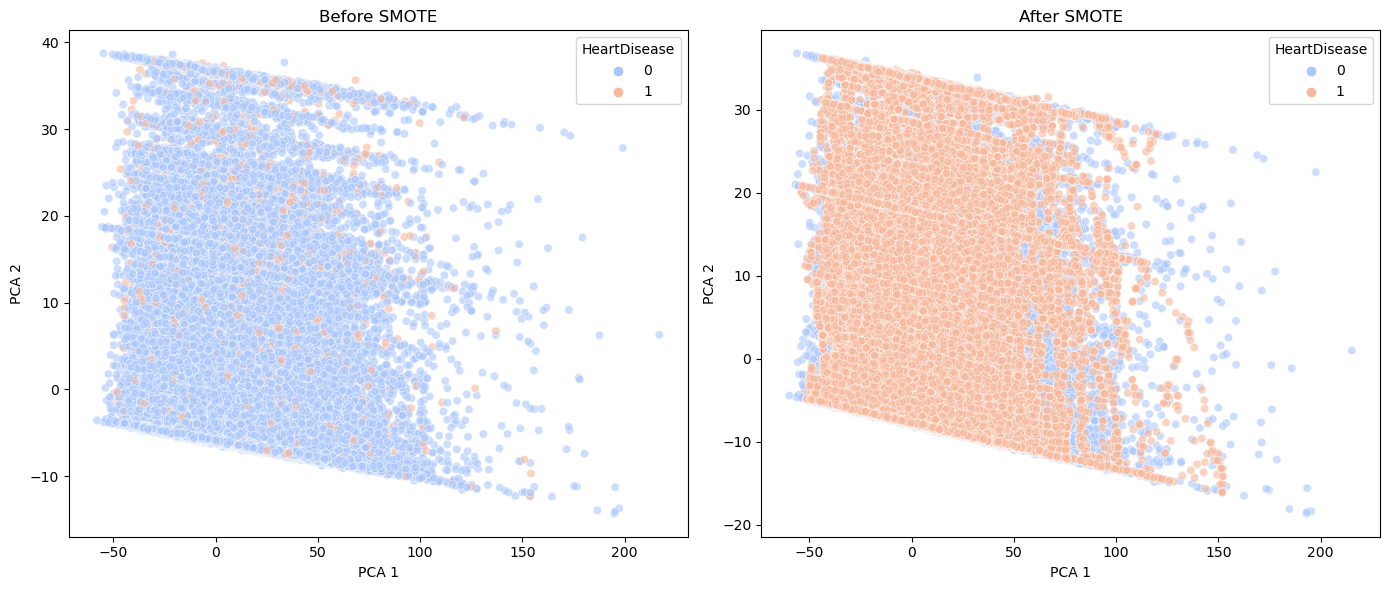

In [15]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca_before = pca.fit_transform(X)
X_pca_after = pca.fit_transform(X_balanced)

# Plotting
plt.figure(figsize=(14, 6))

# Before SMOTE
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca_before[:, 0], y=X_pca_before[:, 1], hue=y, palette='coolwarm', alpha=0.6)
plt.title("Before SMOTE")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

# After SMOTE
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca_after[:, 0], y=X_pca_after[:, 1], hue=y_balanced, palette='coolwarm', alpha=0.6)
plt.title("After SMOTE")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.tight_layout()
plt.show()

In [17]:
print("Shape of X after SMOTE:", X_balanced.shape)
print("Target Distribution after SMOTE:\n", pd.Series(y_balanced).value_counts())

Shape of X after SMOTE: (465102, 38)
Target Distribution after SMOTE:
 HeartDisease
0    232551
1    232551
Name: count, dtype: int64


Synthetic Minority Over-sampling Technique (SMOTE) to the data to address the class imbalance.  It then uses Principal Component Analysis (PCA) to reduce the dimensionality of the data to 2 components for visualization purposes, both before and after applying SMOTE.  Finally, it generates two scatter plots side-by-side: "Before SMOTE" and "After SMOTE," showing the data points in the 2-dimensional PCA space, colored by their class.  The "After SMOTE" plot visually demonstrates that the number of data points for class 1 has increased, making the distribution more balanced compared to the "Before SMOTE" plot.

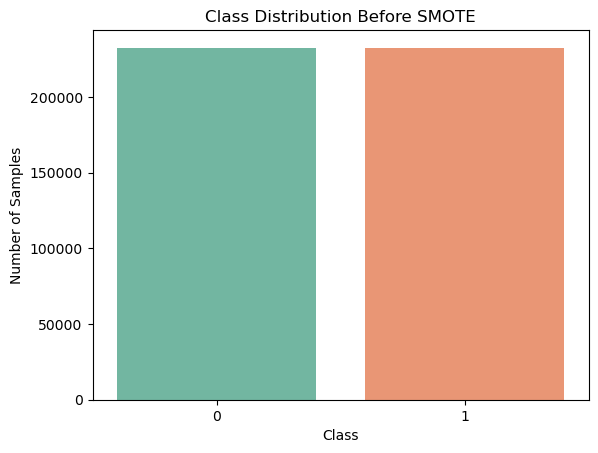

In [18]:
# Basic bar plot for class distribution
sns.countplot(x=y_balanced, palette='Set2')

plt.title("Class Distribution Before SMOTE")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

The output confirms that the number of rows has increased to 465,102 and that the classes in y_balanced are now balanced, with 232,551 samples for each class.

# Split the Dataset

In [20]:
# Split the data
X_temp, X_test, y_temp, y_test = train_test_split(X_balanced, y_balanced, test_size=0.15, random_state=42, stratify=y_balanced)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)  # 0.1765 of 85% is ~15%

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (325559, 38)
Validation set shape: (69777, 38)
Test set shape: (69766, 38)


Splits the balanced data into training, validation, and test sets. It first splits the data into a temporary set (85%) and a test set (15%), and then splits the temporary set into training (85% of temporary, ~72.25% of total) and validation (15% of temporary, ~12.75% of total) sets. Stratification is used to maintain the class distribution in each split. The output shows the shapes of the resulting training, validation, and test sets.

# Hyperturned and Model Training
hyperparameter tuning for an XGBoost classifier

In [21]:
# Hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train)

# Best model
best_xgb_model = random_search.best_estimator_
print("Best parameters:", random_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.2, 'colsample_bytree': 1.0}


It defines a distribution of hyperparameters to sample from, initializes an XGBoost model, and then uses RandomizedSearchCV to find the best combination of parameters based on the F1 score with 3-fold cross-validation on the training data.  The output shows the best parameters found by the search. 

# Saves the best XGBoost model 
Found by RandomizedSearchCV to a joblib file.  It then makes predictions and calculates performance metrics on the validation and test sets.  The metrics calculated include Accuracy, Precision, Recall, F1-Score, AUC-ROC, Log Loss, and Positive Rate.  These metrics are stored in a pandas DataFrame and saved to a CSV file named 'final_model_metrics.csv'.  The output displays the calculated metrics for the XGBoost model on the validation set.

In [22]:
# Save the best model
joblib.dump(best_xgb_model, 'best_model_xgboost.joblib')
print("Model saved as 'best_model_xgboost.joblib'")

# Predictions and Metrics
y_pred_val = best_xgb_model.predict(X_val)
y_prob_val = best_xgb_model.predict_proba(X_val)[:, 1]
y_pred_test = best_xgb_model.predict(X_test)
y_prob_test = best_xgb_model.predict_proba(X_test)[:, 1]

# Calculate metrics
metrics = {
    'Model': 'XGBoost',
    'Accuracy': accuracy_score(y_val, y_pred_val),
    'Precision': precision_score(y_val, y_pred_val, zero_division=0),
    'Recall': recall_score(y_val, y_pred_val, zero_division=0),
    'F1-Score': f1_score(y_val, y_pred_val, zero_division=0),
    'AUC-ROC': roc_auc_score(y_val, y_prob_val),
    'Log Loss': log_loss(y_val, y_prob_val),
    'Positive Rate': sum(y_pred_val) / len(y_pred_val)
}

results_df = pd.DataFrame([metrics])
results_df.to_csv('final_model_metrics.csv', index=False)
print("Metrics table saved as 'final_model_metrics.csv'")
print(results_df)

Model saved as 'best_model_xgboost.joblib'
Metrics table saved as 'final_model_metrics.csv'
     Model  Accuracy  Precision    Recall  F1-Score   AUC-ROC  Log Loss  \
0  XGBoost  0.949711    0.95523  0.943648  0.949404  0.988671  0.132686   

   Positive Rate  
0       0.493931  


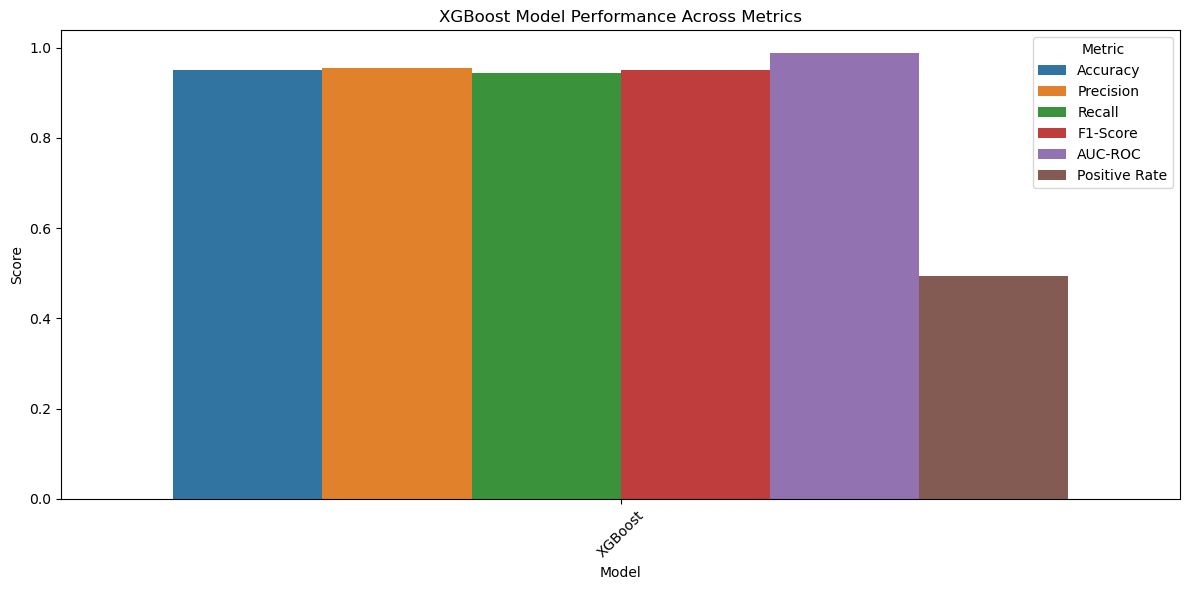

In [23]:
# Visualize metrics
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Positive Rate']
results_melted = results_df.melt(id_vars='Model', value_vars=metrics_to_plot, 
                                 var_name='Metric', value_name='Score')
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=results_melted)
plt.title('XGBoost Model Performance Across Metrics')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_metrics_comparison.png')
plt.show()

The plot titled 'XGBoost Model Performance Across Metrics' shows bars for each metric (Accuracy, Precision, Recall, F1-Score, AUC-ROC, Positive Rate) for the XGBoost model.  This provides a clear visual comparison of how the model performs across different evaluation criteria.

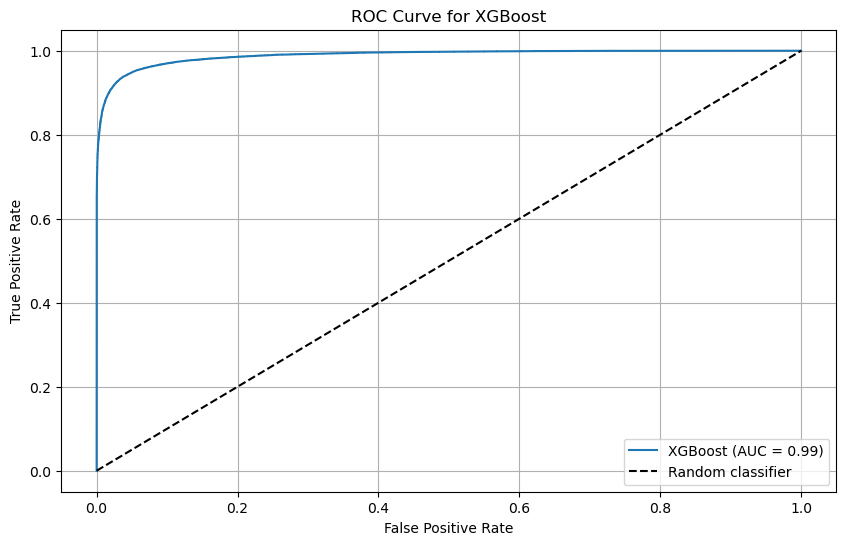

In [24]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_prob_val)
roc_auc = roc_auc_score(y_val, y_prob_val)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_curve_xgboost.png')
plt.show()

It calculates the False Positive Rate (fpr) and True Positive Rate (tpr) and the Area Under the ROC Curve (AUC).  The plot shows the ROC curve for XGBoost along with a dashed line representing a random classifier.  The AUC value is included in the legend, indicating the model's ability to distinguish between the classes.

# Feature Importance

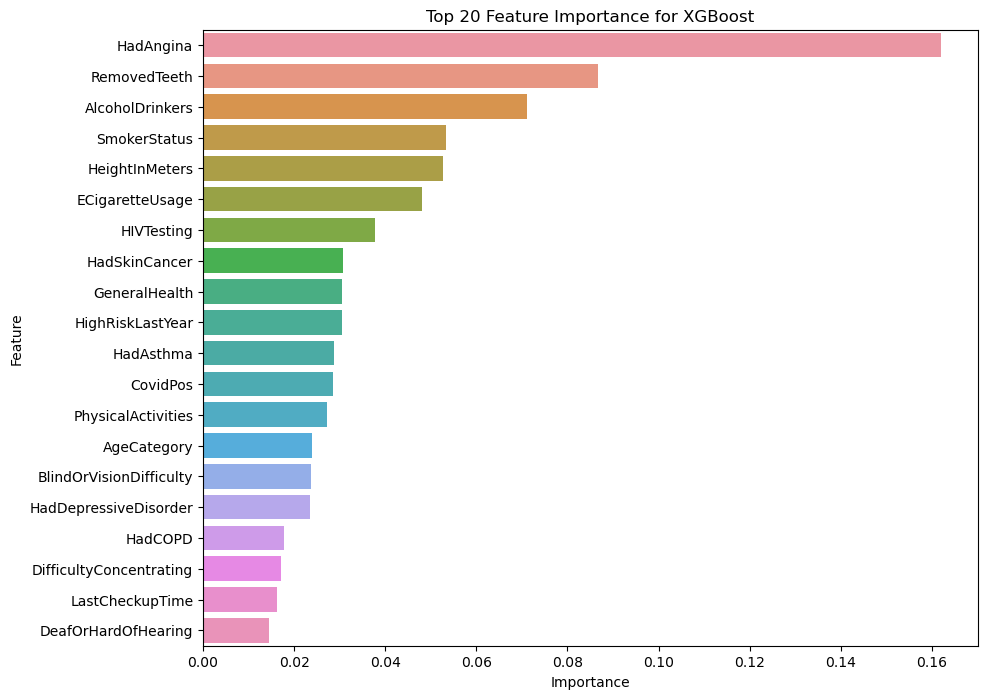

In [25]:
# Visualized Feature Importance
feature_importance = best_xgb_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importance for XGBoost')
plt.savefig('feature_importance_xgboost.png')
plt.show()

It gets the feature importances from the model, creates a DataFrame with feature names and their importance scores, sorts the features by importance, and generates a horizontal bar plot showing the importance of the top 20 features.  The plot titled 'Top 20 Feature Importance for XGBoost' helps identify which features the model considered most influential in making predictions.

# Explainable AI

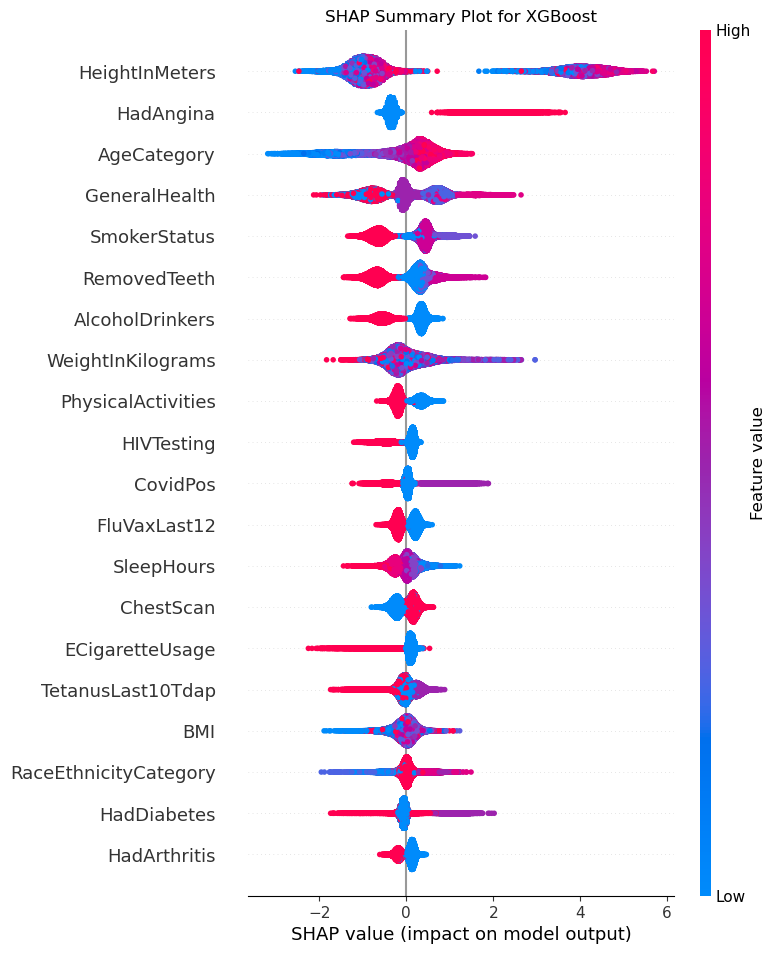

In [26]:
# SHAP Analysis
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot
plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
plt.title('SHAP Summary Plot for XGBoost')
plt.savefig('shap_summary_xgboost.png')
plt.show()

SHAP (SHapley Additive exPlanations) analysis to explain the model's predictions.  It creates a TreeExplainer for the XGBoost model and calculates SHAP values for the test set.  It then generates a SHAP summary plot, which provides an overview of the feature importance and the impact of feature values on the predictions across the test dataset.  The plot titled 'SHAP Summary Plot for XGBoost' shows how much each feature contributes to the prediction for each instance, and the color indicates the feature value.

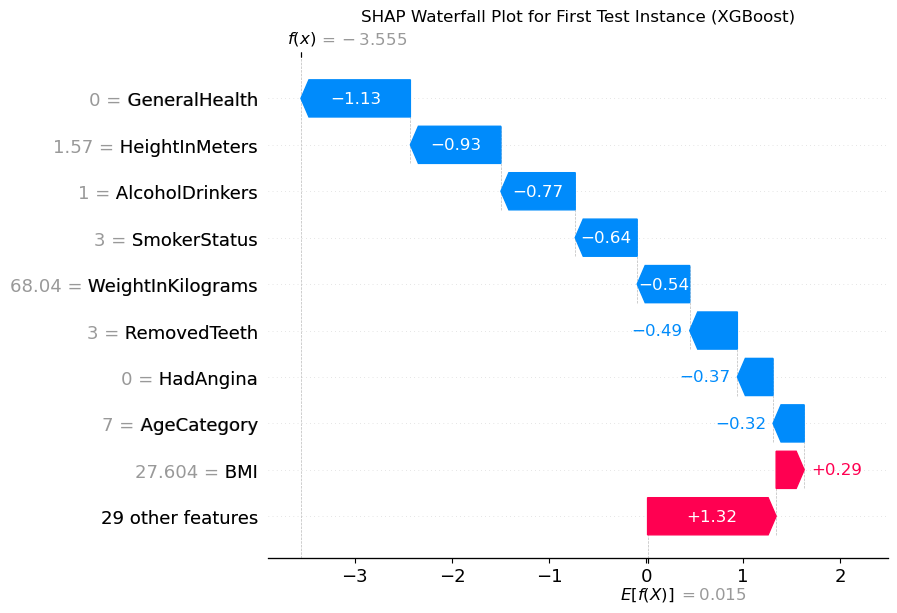

In [27]:
# SHAP Waterfall Plot for the first test instance
shap.waterfall_plot(shap.Explanation(values=shap_values[0], 
                                     base_values=explainer.expected_value, 
                                     data=X_test.iloc[0], 
                                     feature_names=X_test.columns.tolist()), 
                    show=False)
plt.title('SHAP Waterfall Plot for First Test Instance (XGBoost)')
plt.savefig('shap_waterfall_xgboost.png')
plt.show()

SHAP waterfall plot for the first instance in the test set.  A waterfall plot shows how each feature contributes to pushing the model's output from the base value (average prediction) to the final prediction for a single instance.  The plot titled 'SHAP Waterfall Plot for First Test Instance (XGBoost)' details the impact of each feature on the prediction for that specific instance.

In [28]:
# Text-based SHAP explanation
shap_values_instance = shap_values[0]
top_features = np.argsort(np.abs(shap_values_instance))[-3:]  # Top 3 features
text_explanation = f"Prediction for instance 0: {best_xgb_model.predict(X_test.iloc[[0]])[0]}\n"
for idx in top_features:
    feature_name = X_test.columns[idx]
    feature_value = X_test.iloc[0, idx]
    shap_value = shap_values_instance[idx]
    text_explanation += f"Feature '{feature_name}' (value: {feature_value:.2f}) contributed {shap_value:.2f} to the prediction\n"
with open('shap_text_explanation_xgboost.txt', 'w') as f:
    f.write(text_explanation)
print("Text explanation saved as 'shap_text_explanation_xgboost.txt'")
print(text_explanation)

Text explanation saved as 'shap_text_explanation_xgboost.txt'
Prediction for instance 0: 0
Feature 'AlcoholDrinkers' (value: 1.00) contributed -0.77 to the prediction
Feature 'HeightInMeters' (value: 1.57) contributed -0.93 to the prediction
Feature 'GeneralHealth' (value: 0.00) contributed -1.13 to the prediction



A text-based SHAP explanation for the first instance in the test set.  It identifies the top 3 features with the largest absolute SHAP values for that instance and provides a textual description of the prediction and how these top features contributed to it.  This explanation is also saved to a text file.  The output shows the prediction for the instance and the contribution of the top features.

Saves the training, validation, and test sets (features and target variables) to CSV files.  This is useful for later use, such as loading the data into a Flask app for deployment.

In [33]:
# Save datasets
X_train.to_csv('X_train.csv', index=False)
X_val.to_csv('X_val.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# Equal Opportunities

# GENDER

Gender Distribution in Test Set:
Sex
1    35616
0    34150
Name: count, dtype: int64

Male Confusion Matrix Metrics:
TN=15466, FP=890, FN=1027, TP=18233


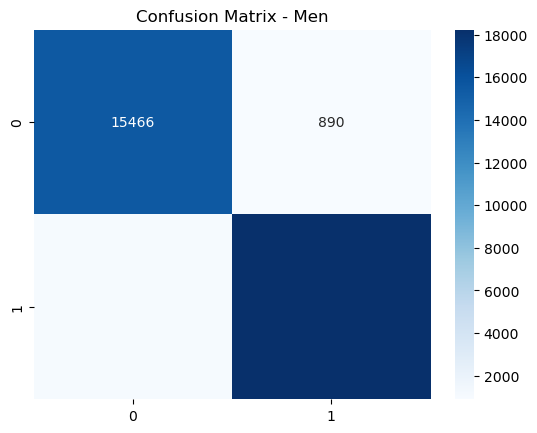

Men Metrics: {'Accuracy': 0.9461758760107817, 'Precision': 0.9534591852742771, 'Recall': 0.9466770508826584, 'F1': 0.9500560143813667, 'ROC-AUC': 0.9875323887734665, 'Positive Rate': 0.5369216082659479}

Female Confusion Matrix Metrics:
TN=17911, FP=616, FN=845, TP=14778


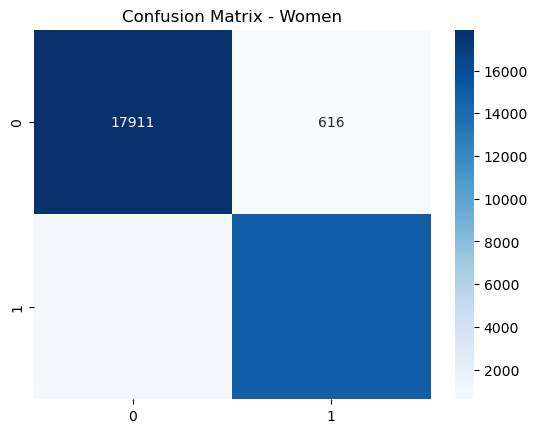

Women Metrics: {'Accuracy': 0.9572181551976574, 'Precision': 0.9599844095101988, 'Recall': 0.9459130768738399, 'F1': 0.9528967985298384, 'ROC-AUC': 0.9900397506183862, 'Positive Rate': 0.45077598828696924}


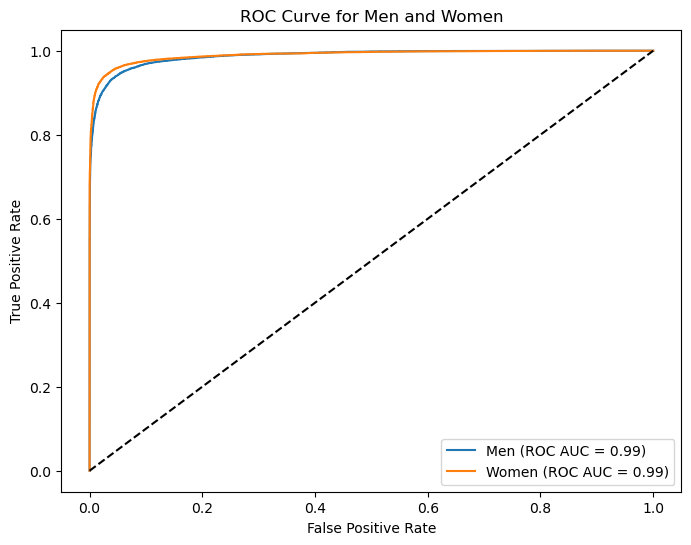

In [29]:
# Fairness Analysis
# Fairness Analysis: Sex
PROTECTED_SEX = 'Sex'
MEN = 1  # Assuming 'Male' was encoded as 1
WOMEN = 0  # Assuming 'Female' was encoded as 0

gender_dist = X_test[PROTECTED_SEX].value_counts()
print("Gender Distribution in Test Set:")
print(gender_dist)

men_indices = np.where(X_test[PROTECTED_SEX] == MEN)[0]
women_indices = np.where(X_test[PROTECTED_SEX] == WOMEN)[0]

y_test_men = y_test.iloc[men_indices]
y_test_women = y_test.iloc[women_indices]
y_pred_men = y_pred_test[men_indices]
y_pred_women = y_pred_test[women_indices]
y_prob_men = y_prob_test[men_indices]
y_prob_women = y_prob_test[women_indices]

# Metrics for Men
cm_male = confusion_matrix(y_test_men, y_pred_men)
tn, fp, fn, tp = cm_male.ravel()
print("\nMale Confusion Matrix Metrics:")
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
sns.heatmap(cm_male, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Men')
plt.savefig('cm_male.png')
plt.show()

metrics_men = {
    'Accuracy': accuracy_score(y_test_men, y_pred_men),
    'Precision': precision_score(y_test_men, y_pred_men, zero_division=0),
    'Recall': recall_score(y_test_men, y_pred_men, zero_division=0),
    'F1': f1_score(y_test_men, y_pred_men, zero_division=0),
    'ROC-AUC': roc_auc_score(y_test_men, y_prob_men) if len(np.unique(y_test_men)) > 1 else 0,
    'Positive Rate': sum(y_pred_men) / len(y_pred_men) if len(y_pred_men) > 0 else 0
}
print("Men Metrics:", metrics_men)

# Metrics for Women
cm_female = confusion_matrix(y_test_women, y_pred_women)
tn, fp, fn, tp = cm_female.ravel()
print("\nFemale Confusion Matrix Metrics:")
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
sns.heatmap(cm_female, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Women')
plt.savefig('cm_female.png')
plt.show()

metrics_women = {
    'Accuracy': accuracy_score(y_test_women, y_pred_women),
    'Precision': precision_score(y_test_women, y_pred_women, zero_division=0),
    'Recall': recall_score(y_test_women, y_pred_women, zero_division=0),
    'F1': f1_score(y_test_women, y_pred_women, zero_division=0),
    'ROC-AUC': roc_auc_score(y_test_women, y_prob_women) if len(np.unique(y_test_women)) > 1 else 0,
    'Positive Rate': sum(y_pred_women) / len(y_pred_women) if len(y_pred_women) > 0 else 0
}
print("Women Metrics:", metrics_women)

# ROC Curve for Sex
plt.figure(figsize=(8, 6))
if len(np.unique(y_test_men)) > 1:
    fpr_men, tpr_men, _ = roc_curve(y_test_men, y_prob_men)
    plt.plot(fpr_men, tpr_men, label=f'Men (ROC AUC = {metrics_men["ROC-AUC"]:.2f})')
if len(np.unique(y_test_women)) > 1:
    fpr_women, tpr_women, _ = roc_curve(y_test_women, y_prob_women)
    plt.plot(fpr_women, tpr_women, label=f'Women (ROC AUC = {metrics_women["ROC-AUC"]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Men and Women')
plt.legend()
plt.savefig('roc_sex.png')
plt.show()

It defines 'Men' and 'Women' based on the encoded values and splits the test set accordingly.  It then calculates and prints confusion matrix metrics (TN, FP, FN, TP) for both men and women, and generates confusion matrix heatmaps for each group.  It also calculates and prints various performance metrics (Accuracy, Precision, Recall, F1, ROC-AUC, Positive Rate) for men and women. Finally, it generates an ROC curve comparing the performance for men and women.  The output shows the gender distribution in the test set and the calculated metrics for each gender.  The ROC curve visually compares the trade-off between true positive rate and false positive rate for both groups. 

In the context of heart disease prediction, these gender-specific metrics provide important insights into how the model behaves differently for men and women:
The higher recall for men (94.67%) means the model is slightly better at identifying male patients who truly have heart disease, which is critical in reducing missed diagnoses.
The higher precision and accuracy for women indicate that when the model predicts heart disease in women, it is more likely to be correct, reducing unnecessary anxiety and follow-up tests from false positives.
The ROC-AUC scores above 0.98 for both genders suggest excellent overall discrimination, but the slightly higher value for women (0.9900) means the model has a better ability to distinguish between diseased and non-diseased cases in females.
The positive prediction rate being higher in men (53.7%) could imply that the model is more inclined to predict heart disease in males, which may reflect real-world data trends or model bias.
The comparable F1 scores (95.0% for men, 95.3% for women) show the model is well-balanced across both genders, but nuanced performance differences hint at areas where calibration or threshold adjustments could improve fairness.

Overall, while the model performs strongly for both, these differences highlight the importance of evaluating and possibly customizing heart disease prediction models by gender to ensure equitable and accurate healthcare outcomes.

# Age Group
It groups age categories into 'Young', 'Adult', and 'Old'  and defines a function evaluate_fairness to calculate and visualize metrics (confusion matrix and various performance metrics) for each group.  It then applies this function to the 'Young', 'Adult', and 'Old' groups based on their indices in the test set  and prints the age distribution and metrics for each group. Finally, it generates an ROC curve comparing the performance across the age groups.  The output shows the age distribution in the test set and the calculated metrics for each age group.  The ROC curve visually compares the model's performance across different age categories.

Age Distribution in Test Set:
AgeCategory
9     10301
10    10252
8      8420
11     8162
7      6453
12     5949
6      4833
5      3594
4      3159
3      2688
2      2160
0      2079
1      1716
Name: count, dtype: int64

Young Confusion Matrix:
TN=5567, FP=10, FN=51, TP=327


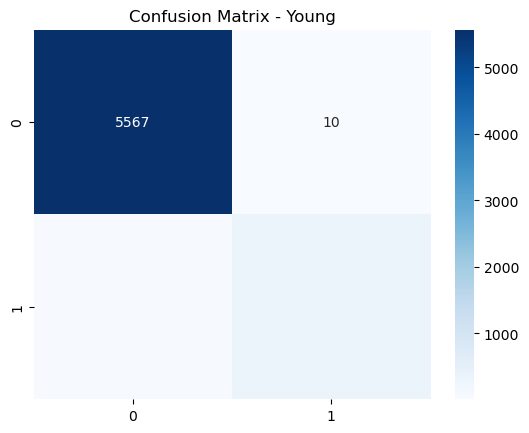

Young Metrics: {'Accuracy': 0.9897565071368598, 'Precision': 0.9703264094955489, 'Recall': 0.8650793650793651, 'F1': 0.9146853146853147, 'ROC-AUC': 0.9881191932473984, 'Positive Rate': 0.05659109991603695}

Adult Confusion Matrix:
TN=16609, FP=441, FN=672, TP=11425


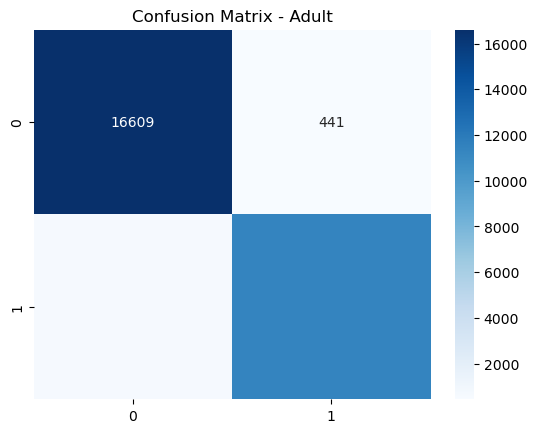

Adult Metrics: {'Accuracy': 0.9618142518955639, 'Precision': 0.9628349907298163, 'Recall': 0.9444490369513102, 'F1': 0.9535533948170095, 'ROC-AUC': 0.9912922110302427, 'Positive Rate': 0.407108793357807}

Old Confusion Matrix:
TN=11201, FP=1055, FN=1149, TP=21259


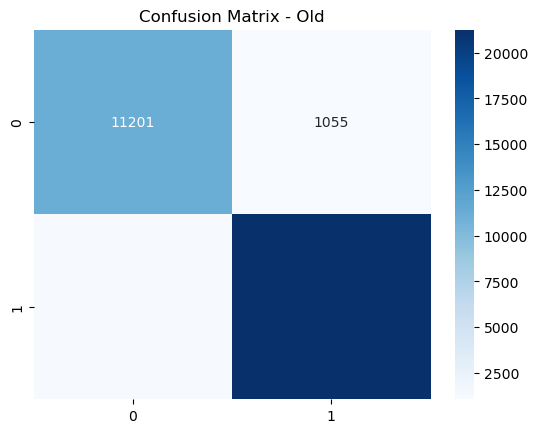

Old Metrics: {'Accuracy': 0.9364181860143088, 'Precision': 0.9527202653042933, 'Recall': 0.9487236701178151, 'F1': 0.9507177675417021, 'ROC-AUC': 0.9814028876150862, 'Positive Rate': 0.6437225940456959}


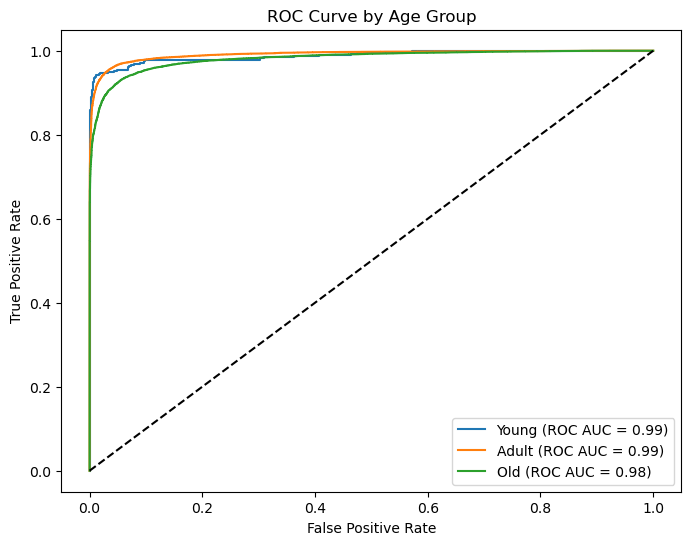

In [34]:
# ----- PREPARATION: Reset Indices for Consistency -----
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
# (Ensure that y_pred_test and y_prob_test are also ordered accordingly)

# --------------------
# Fairness Analysis: Age Category
# --------------------
PROTECTED_AGE = 'AgeCategory'

# Define groupings based on original encoding
# Here, we assume:
# 0: Age 18 to 24, 1: Age 25 to 29, 2: Age 30 to 34, 
# 3: Age 35 to 39, 4: Age 40 to 44, 5: Age 45 to 49,
# 6: Age 50 to 54, 7: Age 55 to 59, 8: Age 60 to 64,
# 9: Age 65 to 69, 10: Age 70 to 74, 11: Age 75 to 79,
# 12: Age 80 or older

YOUNG = [0, 1, 2]                 # Young: 18 to 34
ADULT = [3, 4, 5, 6, 7, 8]         # Adult: 35 to 64
OLD   = [9, 10, 11, 12]            # Old: 65 or older

def evaluate_fairness(group_name, indices):
    y_test_group = y_test.iloc[indices]
    y_pred_group = y_pred_test[indices]
    y_prob_group = y_prob_test[indices]
    
    cm = confusion_matrix(y_test_group, y_pred_group)
    tn, fp, fn, tp = cm.ravel()
    print(f"\n{group_name} Confusion Matrix:")
    print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {group_name}')
    plt.savefig(f'cm_{group_name.lower()}.png')
    plt.show()

    metrics = {
        'Accuracy': accuracy_score(y_test_group, y_pred_group),
        'Precision': precision_score(y_test_group, y_pred_group, zero_division=0),
        'Recall': recall_score(y_test_group, y_pred_group, zero_division=0),
        'F1': f1_score(y_test_group, y_pred_group, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test_group, y_prob_group) if len(np.unique(y_test_group)) > 1 else 0,
        'Positive Rate': sum(y_pred_group) / len(y_pred_group) if len(y_pred_group) > 0 else 0
    }
    print(f"{group_name} Metrics:", metrics)
    return y_test_group, y_prob_group, metrics

print("Age Distribution in Test Set:")
print(X_test[PROTECTED_AGE].value_counts())

young_indices = X_test[X_test[PROTECTED_AGE].isin(YOUNG)].index
adult_indices = X_test[X_test[PROTECTED_AGE].isin(ADULT)].index
old_indices = X_test[X_test[PROTECTED_AGE].isin(OLD)].index

y_young, prob_young, metrics_young = evaluate_fairness("Young", young_indices)
y_adult, prob_adult, metrics_adult = evaluate_fairness("Adult", adult_indices)
y_old, prob_old, metrics_old = evaluate_fairness("Old", old_indices)

# ROC Curve - Age Groups
plt.figure(figsize=(8, 6))
for label, y_true, y_prob in [
    ("Young", y_young, prob_young),
    ("Adult", y_adult, prob_adult),
    ("Old", y_old, prob_old)
]:
    if len(np.unique(y_true)) > 1:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc = roc_auc_score(y_true, y_prob)
        plt.plot(fpr, tpr, label=f'{label} (ROC AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Age Group')
plt.legend()
plt.savefig('roc_age.png')
plt.show()

These age-group-specific metrics reveal how the model performs across different stages of life in heart disease prediction. Young individuals show the highest overall accuracy (98.98%), but their recall is significantly lower (86.5%), meaning the model misses more actual cases of heart disease in this group, likely due to its lower prevalence. Adults benefit from a strong balance, with high precision (96.28%) and recall (94.44%), indicating the model is both accurate and sensitive in detecting true cases. In older adults, the model achieves the highest recall (94.87%) and a strong F1 score (95.07%), suggesting excellent detection of heart disease but with more false positives (1,055), possibly due to higher disease prevalence and overlapping symptoms. The positive prediction rate increases with age, from just 5.6% in the young to 64.4% in the old, reflecting the expected rise in heart disease risk with age. Overall, the model is well-calibrated for adults and seniors but may require adjustment or additional features to improve sensitivity in younger populations, where cases are rare but potentially serious if missed.

# Race/Ethnicity
t defines groupings for 'White', 'Black', 'Hispanic', 'Asian', and 'Other' based on the encoded values  and uses the evaluate_fairness function to calculate and visualize metrics (confusion matrix and various performance metrics) for each racial/ethnic group.  It prints the race/ethnicity distribution and metrics for each group. Finally, it generates an ROC curve comparing the performance across the racial/ethnic groups.  The output shows the race/ethnicity distribution in the test set and the calculated metrics for each group.  The ROC curve visually compares the model's performance across different racial and ethnic categories.

Race/Ethnicity Distribution in Test Set:
RaceEthnicityCategory
4    52441
3     5124
0     4984
1     4983
2     2234
Name: count, dtype: int64

White Confusion Matrix:
TN=2713, FP=97, FN=112, TP=2062


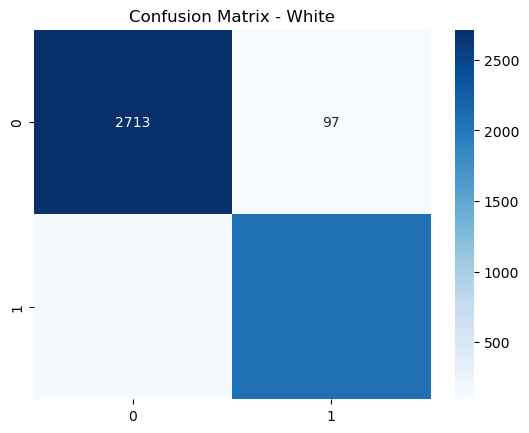

White Metrics: {'Accuracy': 0.9580658105939005, 'Precision': 0.9550717924965262, 'Recall': 0.9484820607175714, 'F1': 0.951765520424648, 'ROC-AUC': 0.9902069753508791, 'Positive Rate': 0.43318619582664525}

Black Confusion Matrix:
TN=3140, FP=93, FN=137, TP=1613


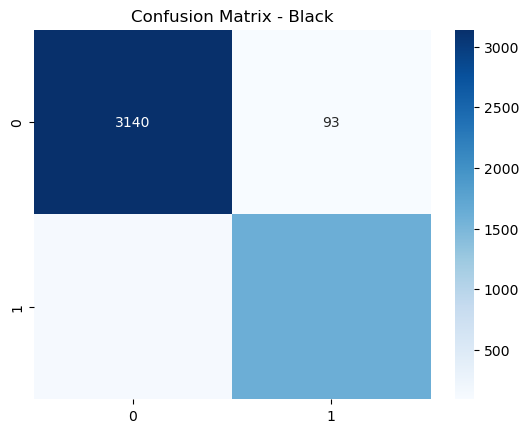

Black Metrics: {'Accuracy': 0.9538430664258479, 'Precision': 0.9454865181711606, 'Recall': 0.9217142857142857, 'F1': 0.9334490740740741, 'ROC-AUC': 0.9890771066236578, 'Positive Rate': 0.3423640377282761}

Hispanic Confusion Matrix:
TN=1681, FP=114, FN=88, TP=3241


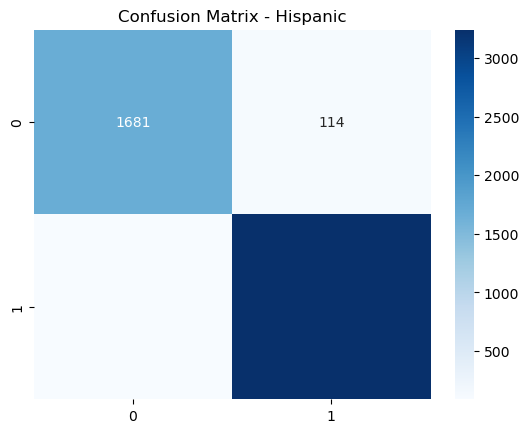

Hispanic Metrics: {'Accuracy': 0.9605776736924277, 'Precision': 0.9660208643815201, 'Recall': 0.9735656353259237, 'F1': 0.9697785757031718, 'ROC-AUC': 0.99298157242298, 'Positive Rate': 0.6547619047619048}

Asian Confusion Matrix:
TN=763, FP=43, FN=48, TP=1380


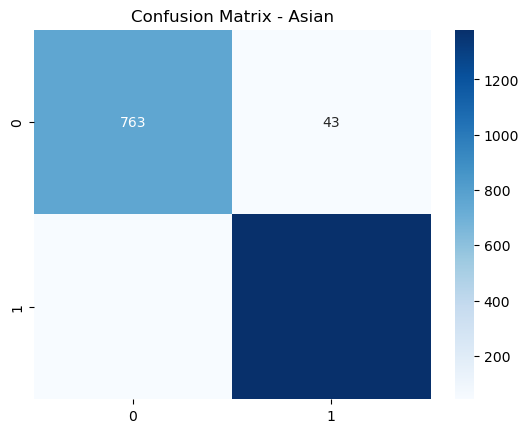

Asian Metrics: {'Accuracy': 0.959265890778872, 'Precision': 0.9697821503865074, 'Recall': 0.9663865546218487, 'F1': 0.9680813749561558, 'ROC-AUC': 0.9916096711637509, 'Positive Rate': 0.6369740376007162}

Other Confusion Matrix:
TN=25080, FP=1159, FN=1487, TP=24715


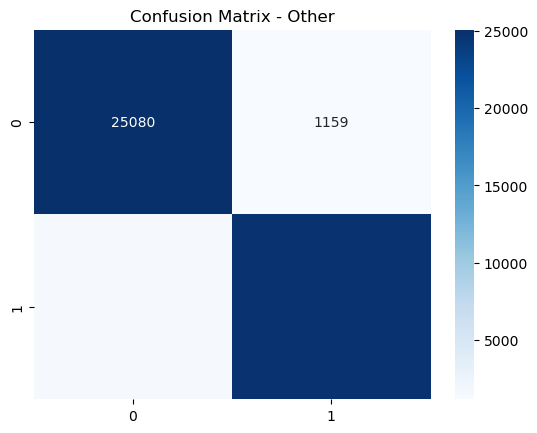

Other Metrics: {'Accuracy': 0.9495432962758147, 'Precision': 0.9552059982994512, 'Recall': 0.9432486069765667, 'F1': 0.949189645902143, 'ROC-AUC': 0.987963735787317, 'Positive Rate': 0.49339257451230906}


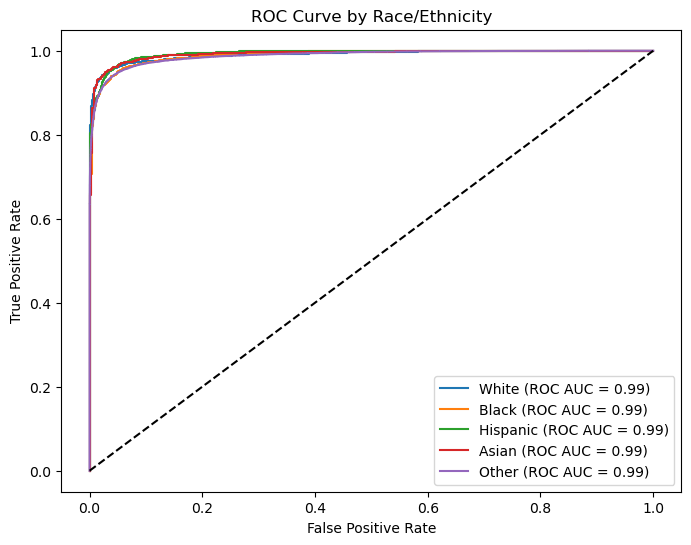

In [35]:
# --------------------
# Fairness Analysis: Race/Ethnicity Category
# --------------------
PROTECTED_RACE = 'RaceEthnicityCategory'

# Define the race/ethnicity mapping:
# We assume the following encoding:
# 0: White only, Non-Hispanic
# 1: Black only, Non-Hispanic
# 2: Multiracial, Non-Hispanic (treated as Asian)
# 3: Hispanic
# 4: Other race only, Non-Hispanic

WHITE    = [0]
BLACK    = [1]
HISPANIC = [3]
ASIAN    = [2]  # Multiracial treated as Asian
OTHER    = [4]

print("Race/Ethnicity Distribution in Test Set:")
print(X_test[PROTECTED_RACE].value_counts())

white_idx = X_test[X_test[PROTECTED_RACE].isin(WHITE)].index
black_idx = X_test[X_test[PROTECTED_RACE].isin(BLACK)].index
hispanic_idx = X_test[X_test[PROTECTED_RACE].isin(HISPANIC)].index
asian_idx = X_test[X_test[PROTECTED_RACE].isin(ASIAN)].index
other_idx = X_test[X_test[PROTECTED_RACE].isin(OTHER)].index

y_white, prob_white, metrics_white = evaluate_fairness("White", white_idx)
y_black, prob_black, metrics_black = evaluate_fairness("Black", black_idx)
y_hispanic, prob_hispanic, metrics_hispanic = evaluate_fairness("Hispanic", hispanic_idx)
y_asian, prob_asian, metrics_asian = evaluate_fairness("Asian", asian_idx)
y_other, prob_other, metrics_other = evaluate_fairness("Other", other_idx)

# ROC Curve - Race/Ethnicity Groups
plt.figure(figsize=(8, 6))
for label, y_true, y_prob in [
    ("White", y_white, prob_white),
    ("Black", y_black, prob_black),
    ("Hispanic", y_hispanic, prob_hispanic),
    ("Asian", y_asian, prob_asian),
    ("Other", y_other, prob_other)
]:
    if len(np.unique(y_true)) > 1:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc = roc_auc_score(y_true, y_prob)
        plt.plot(fpr, tpr, label=f'{label} (ROC AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Race/Ethnicity')
plt.legend()
plt.savefig('roc_race.png')
plt.show()


These race-based performance metrics indicate the model’s predictive fairness and sensitivity across different racial groups in heart disease detection. Hispanic and Asian groups show the strongest performance overall, with very high recall (97.35% and 96.64%) and F1 scores (96.98% and 96.81%), meaning the model is highly accurate at identifying heart disease cases with minimal false negatives. White and Black groups also perform well, with balanced precision and recall, though Black individuals have slightly lower recall (92.17%), suggesting a higher chance of missed diagnoses in this group. The ROC-AUC values are consistently high across all groups, above 0.98, indicating excellent model discrimination capabilities regardless of race. However, the positive prediction rate varies significantly — from 34.2% for Black individuals to 65.4% for Hispanics — which could reflect both true prevalence differences and potential model calibration bias. The “Other” category, despite having the largest sample, shows solid performance but also the highest number of false positives (1,159), which could burden healthcare systems with more follow-up tests. These differences underscore the importance of evaluating model fairness and ensuring performance equity, especially for underrepresented or vulnerable racial groups in clinical predictions.

# For Deployment 
Necessary file save 
Creates a directory named 'flask_app_artifacts' to store the generated artifacts

In [36]:
# Step 11: Save all artifacts for Flask app
artifacts_dir = 'flask_app_artifacts'
os.makedirs(artifacts_dir, exist_ok=True)

In [41]:
# List of files to move
files_to_save = [
    'best_model_xgboost.joblib', 'final_model_metrics.csv', 'model_metrics_comparison.png',
    'roc_curve_xgboost.png', 'feature_importance_xgboost.png', 'shap_summary_xgboost.png',
    'shap_waterfall_xgboost.png', 'shap_text_explanation_xgboost.txt', 'cm_male.png',
    'cm_female.png', 'roc_sex.png', 'roc_age.png', 'roc_race.png', 'X_train.csv',
    'X_val.csv', 'X_test.csv', 'y_train.csv', 'y_val.csv', 'y_test.csv'
] + [f'cm_age_{age}.png' for age in PROTECTED_AGE] + [f'cm_race_{race}.png' for race in PROTECTED_RACE] + \
  [f'label_encoder_{col}.joblib' for col in categorical_cols]

for file in files_to_save:
    if os.path.exists(file):
        os.rename(file, os.path.join(artifacts_dir, file))

print(f"All artifacts saved in '{artifacts_dir}' directory for Flask app usage.")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

All artifacts saved in 'flask_app_artifacts' directory for Flask app usage.
Timestamp: 2025-04-07 13:26:25


In [40]:
#categorical_cols

Index(['Sex', 'GeneralHealth', 'LastCheckupTime', 'PhysicalActivities',
       'RemovedTeeth', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer',
       'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
       'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos'],
      dtype='object')